# Implementing Neural Networks with Backpropagation and Gradient Descent Lab
## Overview
You are a newly hired data scientist at HealthTech Innovations, a healthcare analytics company that works with hospitals to improve patient care through data-driven solutions. Your team has been tasked with developing a predictive model to estimate patient length of stay (LOS) at hospitals. This information is critical for resource allocation, staff scheduling, and financial planning.

Your supervisor has asked you to build a neural network that can predict the length of stay (in days) based on various patient attributes such as age, diagnosis codes, admission type, insurance type, and several health indicators. The goal is to provide hospital administrators with accurate predictions to optimize resource allocation.

This lab will guide you through the process of implementing a neural network using TensorFlow and Keras, focusing specifically on understanding the backpropagation and gradient descent algorithms that power neural network training. You'll follow a similar process to what was demonstrated in the lesson, but with a different dataset and problem context.
## Process
1. Prepare the data
2. Design a neural network architecture
3. Configure the optimization process
4. Train the models
5. Visualize the learning process
6. Evaluate performance

## Tools and Resources
To complete this lab, you will need:

- Python 3.6+
- The following libraries:
    - TensorFlow 2.x
    - Keras (included with TensorFlow)
    - NumPy
    - Pandas
    - Matplotlib
    - Scikit-learn
- Provided Starter Notebook
- Provided Dataset File: patient_los.csv

## Step 0: Libraries and Data Loading
Start by importing all the necessary libraries, setting random seeds for reproducibility, and loading in the provided data.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load the dataset
data = pd.read_csv('patient_los.csv')

## Step 1: Explore the Patient Length-of-Stay Dataset
Begin by understanding the structure and size of your data. Use visuals to help understand basic relationships. The dataset contains information about patients, including demographics, admission details, and health indicators.

In [2]:
numeric_data = ['age', 'num_procedures', 'num_medications', 'comorbidity_score', 'systolic_bp',
                     'diastolic_bp', 'pulse_rate', 'respiratory_rate', 'oxygen_saturation','length_of_stay']

Patient dataset shape: (100000, 14)
Features: 13
Target variable: Length of Stay in Days

Descriptive Statistics:
                 age  num_procedures  num_medications  comorbidity_score  \
count  100000.000000   100000.000000    100000.000000      100000.000000   
mean       54.629980        2.003350         3.003870           1.505150   
std        19.038714        1.419753         1.731411           1.227448   
min        18.000000        0.000000         0.000000           0.000000   
25%        41.000000        1.000000         2.000000           1.000000   
50%        55.000000        2.000000         3.000000           1.000000   
75%        68.000000        3.000000         4.000000           2.000000   
max        95.000000       10.000000        13.000000           9.000000   

         systolic_bp   diastolic_bp     pulse_rate  respiratory_rate  \
count  100000.000000  100000.000000  100000.000000     100000.000000   
mean      129.439160      79.465190      74.542520       

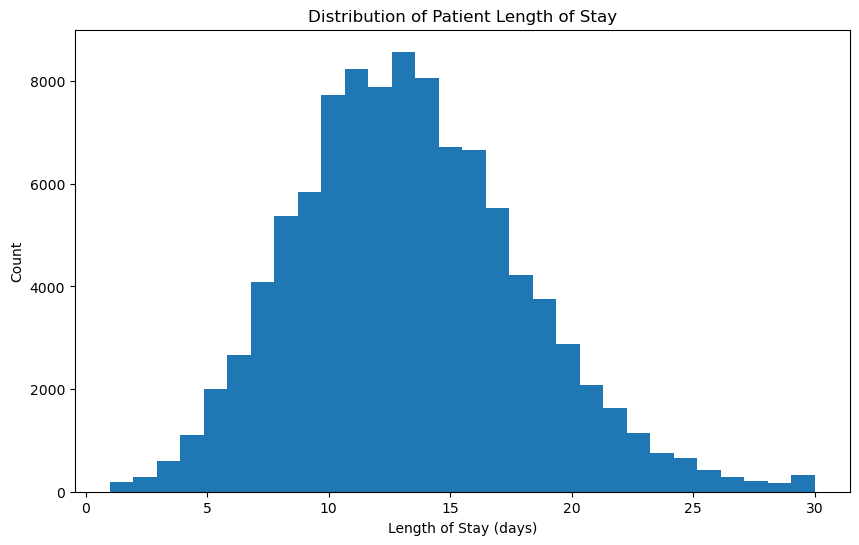

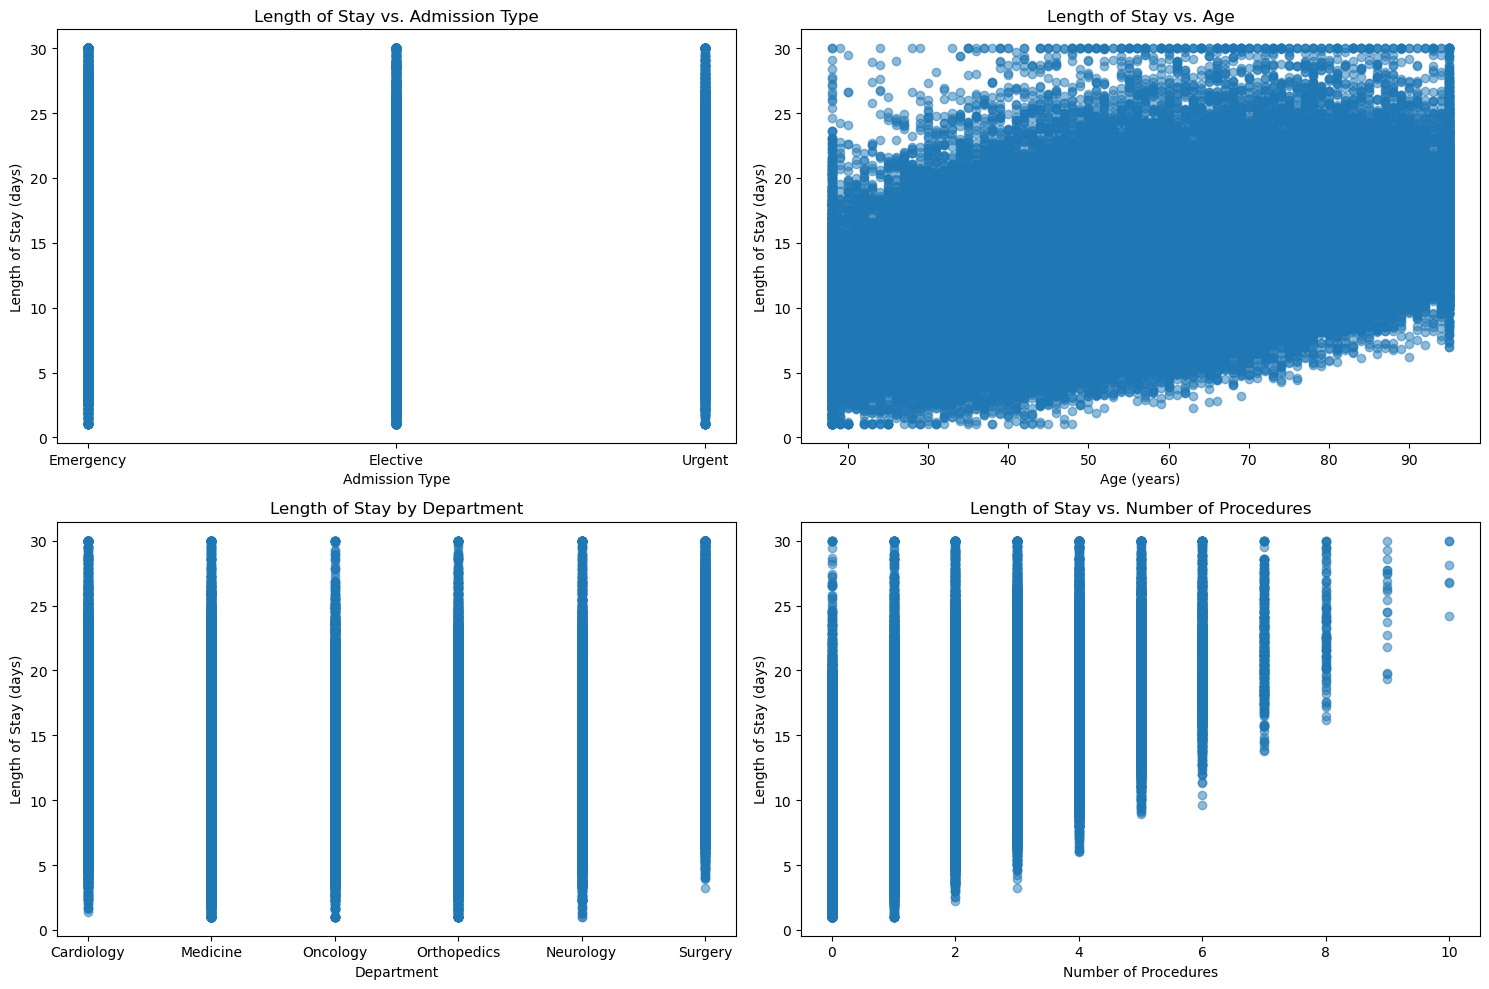


Feature correlations with length of stay:
length_of_stay       1.000000
num_procedures       0.543749
age                  0.403293
comorbidity_score    0.343153
num_medications      0.183447
systolic_bp          0.009127
pulse_rate           0.005593
diastolic_bp         0.004696
oxygen_saturation   -0.003292
respiratory_rate    -0.004677
Name: length_of_stay, dtype: float64


In [3]:
# Display basic information about the dataset
print(f"Patient dataset shape: {data.shape}")
print(f"Features: {data.shape[1] - 1}")
print(f"Target variable: Length of Stay in Days")

# Display basic statistics
print("\nDescriptive Statistics:")
print(data.describe())


# Check for missing values
missing_val_by_col = data.isnull().sum()
print("Missing Values by Column:")
print(missing_val_by_col)

# Visualize the distribution of the target variable (length of stay)
plt.figure(figsize=(10, 6))
plt.hist(data['length_of_stay'], bins=30)
plt.xlabel('Length of Stay (days)')
plt.ylabel('Count')
plt.title('Distribution of Patient Length of Stay')
plt.show()

# Explore relationships between features and target
plt.figure(figsize=(15, 10))

# Admission type
plt.subplot(2, 2, 1)
plt.scatter(data['admission_type'], data['length_of_stay'], alpha=0.5)
plt.xlabel('Admission Type')
plt.ylabel('Length of Stay (days)')
plt.title('Length of Stay vs. Admission Type')

# Age
plt.subplot(2, 2, 2)
plt.scatter(data['age'], data['length_of_stay'], alpha=0.5)
plt.xlabel('Age (years)')
plt.ylabel('Length of Stay (days)')
plt.title('Length of Stay vs. Age')

# Department
plt.subplot(2, 2, 3)
plt.scatter(data['department'], data['length_of_stay'], alpha=0.5)
plt.xlabel('Department')
plt.ylabel('Length of Stay (days)')
plt.title('Length of Stay by Department')

# Number of Procedures
plt.subplot(2, 2, 4)
plt.scatter(data['num_procedures'], data['length_of_stay'], alpha=0.5)
plt.xlabel('Number of Procedures')
plt.ylabel('Length of Stay (days)')
plt.title('Length of Stay vs. Number of Procedures')

plt.tight_layout()
plt.show()

# Calculate correlations with the target variable (numeric only)
correlations = data[numeric_data].corr()['length_of_stay'].sort_values(ascending=False)
print("\nFeature correlations with length of stay:")
print(correlations)

## Step 2: Prepare the Data for Training
Preprocess the data by splitting into training and testing sets and then create a column transformer pipeline that will one hot encode categorical features and standard scale numeric features.

In [ ]:
# Separate features and target
X = data.iloc[:, :13]
y = data['length_of_stay']

# Split the data into training and testing sets (test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get list of numerical and categorical columns
numerical_cols = ['num_procedures', 'num_medications', 'comorbidity_score', 'systolic_bp',
                     'diastolic_bp', 'pulse_rate', 'respiratory_rate', 'oxygen_saturation']
categorical_cols = ['emergency_admission', 'admission_type', 'insurance_type', 'department']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Fit the preprocessor on training data only
X_train_processed = pd.DataFrame(preprocessor.fit(X_train))
# Apply the same transformation to test data
X_test_processed = pd.DataFrame(preprocessor.fit(X_test))

# Get feature names after one-hot encoding (optional, for reference)
ohe_feature_names = []
if categorical_cols:
    ohe = preprocessor.named_transformers_['cat']
    ohe_categories = ohe.categories_
    ohe_feature_names = []
    for i, category in enumerate(ohe_categories):
        cat_col = categorical_cols[i]
        # Skip first category (due to drop='first')
        for cat in category[1:]:
            ohe_feature_names.append(f"{cat_col}_{cat}")

feature_names = numerical_cols + ohe_feature_names

print(f"Training set shape: {X_train_processed.shape}")
print(f"Testing set shape: {X_test_processed.shape}")
print(f"Number of features after encoding: {X_train_processed.shape[1]}")

IndexingError: Too many indexers

## Step 3: Build a Neural Network Model
Design a neural network architecture for the regression task of predicting patient length of stay.

In [ ]:
# Get the number of input features
input_dim = None

# Build a sequential model
model = keras.Sequential([
    # Input layer with the appropriate input shape
    keras.layers.Input(None),
    
    # First hidden layer with 64 neurons and ReLU activation
    None,
    
    # Second hidden layer with 32 neurons and ReLU activation
    None,
    
    # Output layer with a single neuron (for regression)
    None
])

# Display the model summary
model.summary()

## Step 4: Configure the Training Process
Configure the model for training by selecting an optimizer, loss function, and evaluation metrics.

In [ ]:
# Create and compile three different models with different optimizers
loss = 'mean_squared_error'
metric = ['mae']

# Model 1: Using SGD (Stochastic Gradient Descent)
model_sgd = keras.models.clone_model(model)
# Compile
None

# Model 2: Using RMSprop
model_rmsprop = keras.models.clone_model(model)
# Compile
None

# Model 3: Using Adam
model_adam = keras.models.clone_model(model)
# Compile
None

# Defined number of epochs and batch size
epochs = 50
batch_size = 32

## Step 5: Train the Models and Analyze Learning
Train the three models with different optimizers and analyze their learning patterns. Make sure to use `validation_split=0.2`

In [ ]:
# Train the model with SGD
history_sgd = None

# Train the model with RMSprop
history_rmsprop = None

# Train the model with Adam
history_adam = None

# Plot training & validation loss for all three models - include label for each
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 1, 1)
# Training loss SGD
plt.plot(None)
# Validation loss SGD
plt.plot(None, linestyle='--')
# Training loss RMSProp
plt.plot(None)
# Validation loss RMSProp
plt.plot(None, linestyle='--')
# Training loss Adam
plt.plot(None)
# Validation loss Adam
plt.plot(None, linestyle='--')
plt.title('Model Loss Comparison')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# MAE comparison
plt.subplot(2, 1, 2)
# Training MAE SGD
plt.plot(None)
# Validation MAE SGD
plt.plot(None, linestyle='--')
# Training MAE RMSProp
plt.plot(None)
# Validation MAE RMSProp
plt.plot(None, linestyle='--')
# Training MAE Adam
plt.plot(None)
# Validation MAE Adam
plt.plot(None, linestyle='--')

plt.title('Model MAE Comparison')
plt.ylabel('Mean Absolute Error (days)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics for each optimizer
print("Final metrics:")
print(f"SGD - Training Loss: {history_sgd.history['loss'][-1]:.4f}, Validation Loss: {history_sgd.history['val_loss'][-1]:.4f}")
print(f"SGD - Training MAE: {history_sgd.history['mae'][-1]:.4f}, Validation MAE: {history_sgd.history['val_mae'][-1]:.4f}")
print(f"RMSprop - Training Loss: {history_rmsprop.history['loss'][-1]:.4f}, Validation Loss: {history_rmsprop.history['val_loss'][-1]:.4f}")
print(f"RMSprop - Training MAE: {history_rmsprop.history['mae'][-1]:.4f}, Validation MAE: {history_rmsprop.history['val_mae'][-1]:.4f}")
print(f"Adam - Training Loss: {history_adam.history['loss'][-1]:.4f}, Validation Loss: {history_adam.history['val_loss'][-1]:.4f}")
print(f"Adam - Training MAE: {history_adam.history['mae'][-1]:.4f}, Validation MAE: {history_adam.history['val_mae'][-1]:.4f}")

## Step 6: Evaluate Model Performance on Test Data
Select the best-performing model based on validation results, and evaluate it on the test set.

In [ ]:
# Determine the best model based on validation loss
val_losses = [
    history_sgd.history['val_loss'][-1],
    history_rmsprop.history['val_loss'][-1], 
    history_adam.history['val_loss'][-1]
]

best_model_idx = np.argmin(val_losses)
best_models = [model_sgd, model_rmsprop, model_adam]
best_model = best_models[best_model_idx]
best_optimizer = ['SGD', 'RMSprop', 'Adam'][best_model_idx]

print(f"The best performing model used the {best_optimizer} optimizer.")

# Evaluate the best model on the test set
test_loss, test_mae = None
print(f"\nTest Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f} days")

# Make predictions with the best model - hint - make sure to flatten
predictions = None
errors = None

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Length of Stay (days)')
plt.ylabel('Predicted Length of Stay (days)')
plt.title('Actual vs. Predicted Length of Stay')
plt.grid(True, alpha=0.3)
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate additional error metrics
mae = None
mse = None
rmse = None
mean_error = np.mean(errors)
median_error = np.median(errors)
max_error = np.max(np.abs(errors))

print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"Mean Error: {mean_error:.2f} days")
print(f"Median Error: {median_error:.2f} days")
print(f"Maximum Error: {max_error:.2f} days")

# Analyze errors by patient characteristics
# Join predictions with original test data for analysis
test_indices = y_test.index
test_data = data.iloc[test_indices].copy()
test_data['predicted_los'] = None
test_data['error'] = None
test_data['abs_error'] = None

# Example: Error by age group
test_data['age_group'] = pd.cut(test_data['age'], bins=[0, 18, 35, 50, 65, 100], 
                               labels=['0-18', '19-35', '36-50', '51-65', '65+'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='abs_error', data=test_data)
plt.title('Prediction Error by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Absolute Error (days)')
plt.grid(True, alpha=0.3)
plt.show()

## Step 7: Final Evaluation and Analysis
Evaluate the performance of your best model and generate key insights for stakeholders.

In [ ]:
# Calculate performance within different error margins
within_1day = None
within_2days = None
within_3days = None

print("\nPrediction Accuracy:")
print(f"Predictions within 1 day of actual: {within_1day:.1f}%")
print(f"Predictions within 2 days of actual: {within_2days:.1f}%")
print(f"Predictions within 3 days of actual: {within_3days:.1f}%")

# Analyze which types of cases are most difficult to predict
# Group test cases by quartiles of error magnitude
test_data['error_quartile'] = pd.qcut(test_data['abs_error'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

# Examine characteristics of the highest error cases
high_error_cases = test_data[test_data['error_quartile'] == 'Q4']

print("\nCharacteristics of Difficult-to-Predict Cases:")
print(f"Average age: {high_error_cases['age'].mean():.1f} years")
print(f"Average length of stay: {high_error_cases['length_of_stay'].mean():.1f} days")
print(f"Average number of procedures: {high_error_cases['num_procedures'].mean():.1f}")

# Generate insights for stakeholders
print("\nKey Insights for Hospital Administrators:")
print("1. The model can predict patient length of stay with an average error of " +
      f"{np.mean(np.abs(errors)):.2f} days.")
print(f"2. {within_2days:.1f}% of predictions are within 2 days of the actual length of stay.")
print("3. The model has similar error for all age groups indicating no systemic age bias.")